# Project: Simple Denoising Autoencoder

## Objectives of the Project
1) Getting familiar with tensorflow 
2) Get impressions of the noise reduction capabilities of the DAE

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

### Load the Data

In [4]:
(train_set,_), (val_set,_) = tf.keras.datasets.mnist.load_data()

train_set = train_set / 255.0
val_set = val_set / 255.0

train_set = tf.convert_to_tensor(train_set, dtype=tf.float32)
val_set = tf.convert_to_tensor(val_set, dtype=tf.float32)

train_set = tf.expand_dims(train_set, axis=-1)
val_set = tf.expand_dims(val_set, axis=-1)



#### Check Dimensions of a Data Point

In [42]:
print(train_set.shape)

(60000, 28, 28, 1)


### We need to add some gaussian noise onto the data

In [7]:
def add_noise(image,y):
    factor = 0.3
    noise = tf.random.normal(shape=tf.shape(image), mean=0.,stddev=1.0)
    noisy_img = tf.clip_by_value(image+factor*noise,0.,1.)
    return noisy_img, y



### Set batch size and create data sets for training and test

In [8]:
batch_size = 128

train_ds_origin = tf.data.Dataset.from_tensor_slices((train_set,train_set))
val_ds = tf.data.Dataset.from_tensor_slices((val_set,val_set))

In [9]:
train_ds = train_ds_origin.map(lambda x,y: add_noise(x,y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)


val_ds = val_ds.map(lambda x,y: add_noise(x,y), num_parallel_calls=tf.data.AUTOTUNE)

### Visualize noisy pics

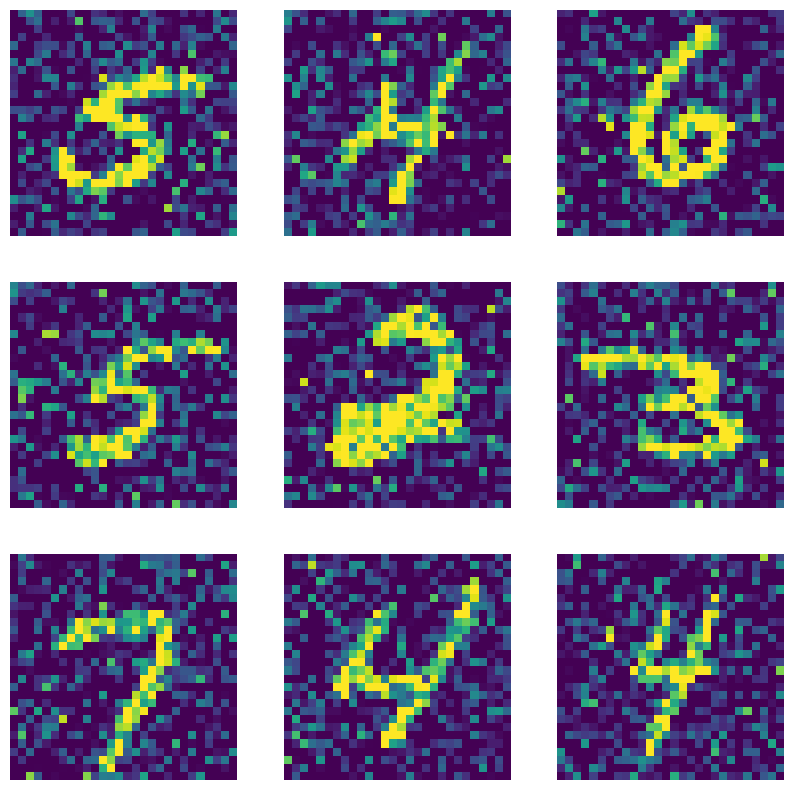

In [67]:
for bilder,ys in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(bilder[i].numpy().astype("float32"))
        #plt.title(f"Label: {train_set.class_names[labels[i]]}")
        plt.axis("off")
        

     


### Set the simple architecture without skip-connections

In [ ]:
_lambda= 0.001
encoder1 = tf.keras.Sequential([
   layers.Input(shape=(28,28,1)),
   layers.Conv2D(16, 3, activation="relu", padding="same",kernel_regularizer=regularizers.l2(_lambda)),
   layers.BatchNormalization(),
   layers.MaxPooling2D(2,padding="same"),
   layers.Conv2D(32,3, activation="relu", padding="same",kernel_regularizer=regularizers.l2(_lambda)),
   layers.BatchNormalization(),
   layers.MaxPooling2D(2,padding="same"),
   layers.Conv2D(64,3, activation="relu", padding="same",kernel_regularizer=regularizers.l2(_lambda)),
   layers.BatchNormalization(),
], name="encoder1")
encoder1.summary()

decoder1 = tf.keras.Sequential([
   layers.Input(shape=(7,7,64)),
   layers.UpSampling2D(2),
   layers.Conv2D(32,3, activation="relu", padding="same"),
   layers.BatchNormalization(),
   layers.UpSampling2D(2),
   layers.Conv2D(16,3, activation="relu", padding="same"),
   layers.BatchNormalization(),
   layers.Conv2D(1,3, activation="sigmoid", padding="same"),
   layers.BatchNormalization(),
], name="decoder1")
decoder1.summary()

Model: "encoder1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,744 (92.75 KB)

 Trainable params: 23,520 (91.88 KB)

 Non-trainable params: 224 (896.00 B)

Model: "decoder1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d_20 (UpSampling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 28, 28, 1)      │           145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 28, 28, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,429 (91.52 KB)

 Trainable params: 23,331 (91.14 KB)

 Non-trainable params: 98 (392.00 B)

### define the autoencoder

In [69]:
input = tf.keras.Input(shape=(28,28,1))
enc = encoder1(input)
dec = decoder1(enc)
ae = tf.keras.Model(input, dec, name="ae1")

### set optimizer and loss function

In [70]:
ae.compile(optimizer="adam", loss="mse")
ae.summary()

Model: "ae1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder1 (Sequential)           │ (None, 7, 7, 64)       │        23,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder1 (Sequential)           │ (None, 28, 28, 1)      │        23,429 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,173 (184.27 KB)

 Trainable params: 46,851 (183.01 KB)

 Non-trainable params: 322 (1.26 KB)

Optimize and use early stopping

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",          
    patience=5,                 
    restore_best_weights=True   
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_model.keras",     
    monitor="val_loss",
    save_best_only=True,             
    save_weights_only=False         
)

In [77]:
history = ae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 186ms/step - loss: 0.0057 - val_loss: 1.5497
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 184ms/step - loss: 0.0055 - val_loss: 0.8883
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 187ms/step - loss: 0.0054 - val_loss: 0.4631
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - loss: 0.0053 - val_loss: 0.2154
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 186ms/step - loss: 0.0052 - val_loss: 0.1326
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 188ms/step - loss: 0.0051 - val_loss: 0.0915
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 86s 182ms/step - loss: 0.0050 - val_loss: 0.0814
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - loss: 0.0050 - val_loss: 0.0719
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 172ms/step - loss: 0.0049 - val_loss: 0.0750
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 88s 189ms/step - loss: 0.0048 - val_loss: 0.0834


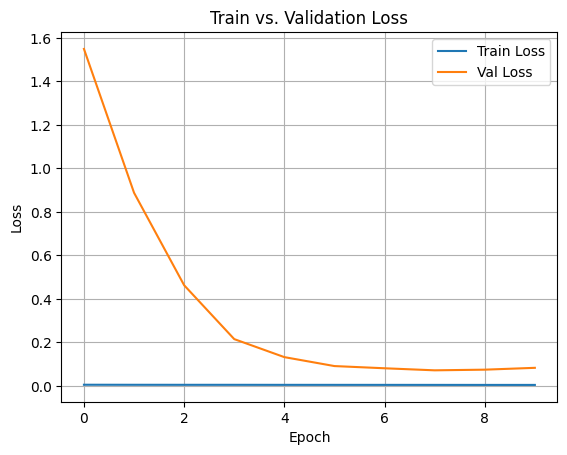

In [78]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.title("Train vs. Validation Loss")
plt.show()

### Load the best model from early stopping

In [5]:
best_model = tf.keras.models.load_model("best_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


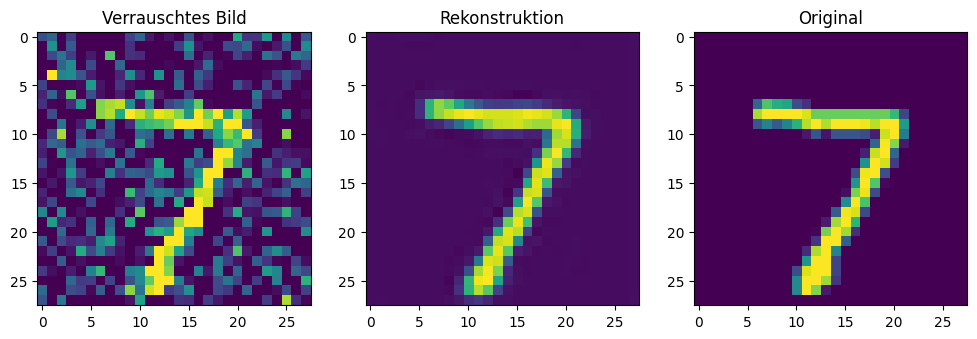

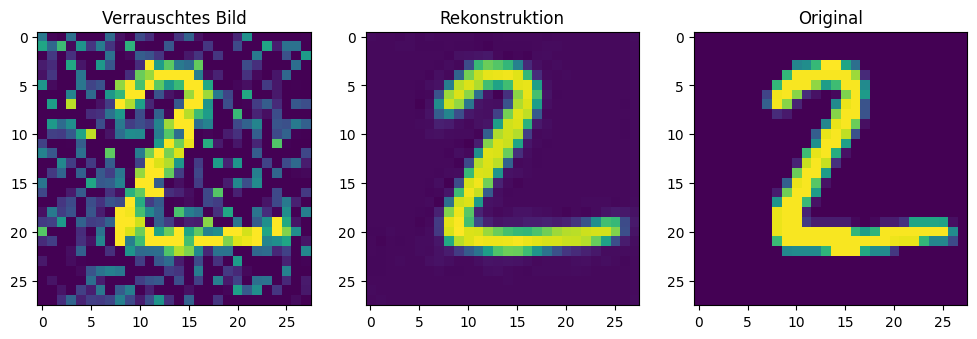

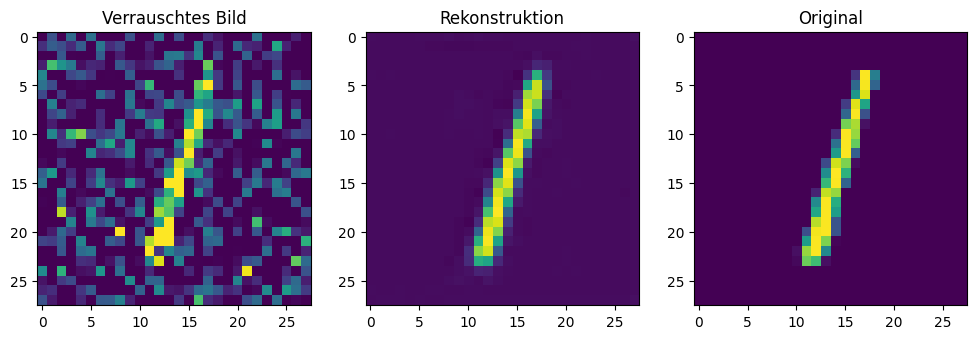

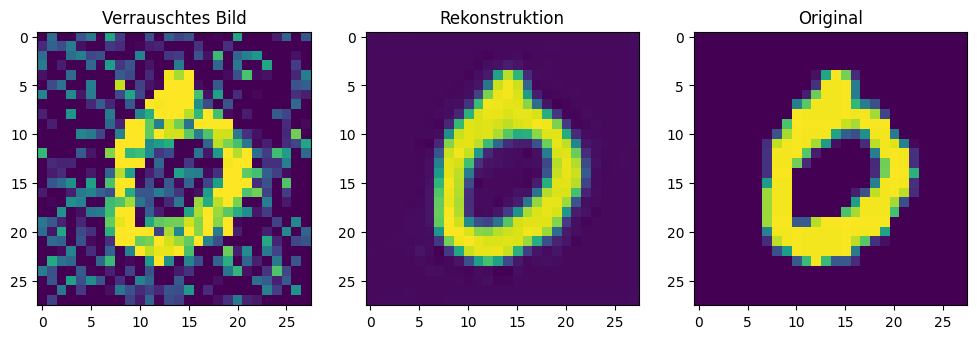

In [ ]:

for x,y in val_ds.batch(1).take(4):

    pred = best_model.predict(x)
    y = tf.squeeze(y)
    x = tf.squeeze(x)
    pred = tf.squeeze(pred)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(x)
    axes[0].set_title("Noisy Img")

    axes[1].imshow(pred)
    axes[1].set_title("Reconstruction")

    axes[2].imshow(y)
    axes[2].set_title("Original")
